In [0]:
%run "./00-Configuracao"

Leitura das credenciais de forma segura pelo Spark 🔐


Caminhos definidos:
📂 Bronze: s3a://mvp-brasileirao-2024/bronze/ | 📂 Silver: s3a://mvp-brasileirao-2024/silver/ | 📂 Gold: s3a://mvp-brasileirao-2024/gold/


✅ Credenciais configuradas com sucesso!


✅ Conexão bem-sucedida! Arquivos encontrados na camada Bronze e Silver:


In [0]:
%run "./06B-Conexao-Databricks-com-DW-Redshift"

Leitura das credenciais de forma segura pelo Spark 🔐


Caminhos definidos:
📂 Bronze: s3a://mvp-brasileirao-2024/bronze/ | 📂 Silver: s3a://mvp-brasileirao-2024/silver/ | 📂 Gold: s3a://mvp-brasileirao-2024/gold/


✅ Credenciais configuradas com sucesso!


✅ Conexão bem-sucedida! Arquivos encontrados na camada Bronze e Silver:


✅ Conexão realizada com sucesso!


✅ Leitura "df_desemp_clubes" feita com sucesso !


✅ Leitura "df_desemp_jogadores" feita com sucesso !


✅ Leitura "df_class_tier" feita com sucesso !


✅ Leitura "df_todas_partidas" feita com sucesso !


✅ Leitura "df_info_jogadores" feita com sucesso !


Out[28]: DataFrame[]

# 📌 Perguntas definidas no inicio do Projeto e respectivas Respostas

### 0️⃣1️⃣ Qual a posição final do São Paulo no Campeonato Brasileiro de 2024?

In [0]:
%sql
SELECT DISTINCT
    c.clube,
    c.posicao,
    t.liga,
    t.pais,
    T.temporada
FROM marts_mvp_brasileirao.classificacao_tier c
LEFT JOIN marts_mvp_brasileirao.todas_partidas t
ON c.clube = t.clube
WHERE c.clube = "São Paulo"

clube,posicao,liga,pais,temporada
São Paulo,6,Serie A,Brazil,2024


#### 0️⃣1️⃣ 🎯 Resposta

São Paulo finalizou o Campeonato Brasileiro na Sexta Posição

---

### 0️⃣2️⃣ Qual foi o resumo do desempenho final do São Paulo no Brasileirão 2024? 
#### Retornar os seguintes campos:
> - Pontuação final  
> - Número de vitórias, empates e derrotas  
> - Gols marcados e gols sofridos  
> - Gols Marcados e Sofridos 


In [0]:
%sql
SELECT DISTINCT
    c.clube,
    c.pontuacao,
    c.vitorias,
    c.derrotas,
    c.empates,
    c.gols_marcados,
    c.gols_sofridos,
    t.liga,
    t.pais,
    t.temporada
FROM marts_mvp_brasileirao.classificacao_tier c
LEFT JOIN marts_mvp_brasileirao.todas_partidas t
ON c.clube = t.clube
WHERE c.clube = "São Paulo"

clube,pontuacao,vitorias,derrotas,empates,gols_marcados,gols_sofridos,liga,pais,temporada
São Paulo,59,17,13,8,53,43,Serie A,Brazil,2024


#### 0️⃣2️⃣ 🎯 Resposta 

São Paulo termina o Campeonato Brasileiro com:
- 59 Pontos
- 17 Vitórias | 8 Empates | 13 Derrotas
- Marcou 53 gols
- Sofreu 43 gols

---

### 0️⃣3️⃣ Em qual Tier o São Paulo finalizou o campeonato? 
###Compare os gols marcados e sofridos com a média dos clubes do mesmo Tier, retornando os valores em percentual.


In [0]:
%sql
SELECT DISTINCT
    c.clube,
    c.tier_clubes,
    c.gols_marcados,
    c.avg_gols_marcados_tier,
    CONCAT(ROUND((c.gols_marcados / c.avg_gols_marcados_tier - 1) * 100, 2), '%') AS gols_marcados_tier_percent,
    c.gols_sofridos,
    c.avg_gols_sofridos_tier,
    CONCAT(ROUND((c.gols_sofridos / c.avg_gols_sofridos_tier - 1) * 100, 2), '%') AS gols_sofridos_tier_percent

FROM marts_mvp_brasileirao.classificacao_tier c
WHERE c.clube = "São Paulo"

clube,tier_clubes,gols_marcados,avg_gols_marcados_tier,gols_marcados_tier_percent,gols_sofridos,avg_gols_sofridos_tier,gols_sofridos_tier_percent
São Paulo,TIER A,53,48.4,9.5%,43,46.8,-8.12%


#### 0️⃣3️⃣ 🎯 Resposta 

São Paulo termina o Campeonato no Tier A (um abaixo do maior tier que é o S).

Outros clubes que estão no mesmo Tier A que o São Paulo, tem os seguintes desempenhos:
- Média de Gols Marcador Tier A = 48,4
- Média de Gols Sofridos Tier A = 46,8

Comparando o São Paulo com esses clubes do mesmo tier:
- São Paulo marca 9,5% de gols a mais que a média desses clubes
- São Paulo sofre 8,12% gols a menos que a média desses clubes

---


### 0️⃣4️⃣ Qual a soma de gols feitos e sofridos no 1º turno x 2º turno?
### E a soma de gols feitos e sofridos por trimestre?

#### 💠 Explicação - AUTO JOIN

Na tabela `todas_partidas` cada uma das partidas estão preenchidas em 2 linhas, que estão ligadas pelo `match_id`.

Para exemplificar melhor, abaixo o exemplo de uma partida cadastrada em `todas_partidas`

| clube   |mandantevisitante| goals | resultado | match_id | data      |
|---------|-----------------|-------|-----------|----------|-----------|
|São Paulo| Mandante        |  2    | Vitória   |  Match_4 |2024-06-27 |
|Criciúma | Visitante       |  1    | Derrota   |  Match_4 |2024-06-27 |


Para identificarmos os adversários com quem o São Paulo jogou nessa tabela, teremos de fazer 4 coisas:

- AUTO JOIN (JOIN com a própria tabela)
- Critério 1 → `match_id` precisam ser iguais (corresponde a mesma partida)
- Critério 2 → `t1.clube != t2.clube`, o clube da primeira tabela sempre será o São Paulo, logo precisamos do segundo clube daquela partida que é o adversário do São Paulo
- Critério 3 → `WHERE t1.clube = 'São Paulo'`, isso garante que o clube da t1 sempre será o São Paulo

Agora conseguimos responder essa perguntar com tranquilidade


In [0]:
%sql
SELECT 
    t1.match_id,
    t1.clube AS clube,
    t1.goals AS gols_marcados,
    t2.goals AS gols_sofridos,
    t2.clube AS adversario,
    t1.turno,
    t1.trimestre,
    t1.data
FROM marts_mvp_brasileirao.todas_partidas t1
-- AUTO JOIN
JOIN marts_mvp_brasileirao.todas_partidas t2
    -- Partidas precisam ser iguais AND Segundo clube precisa ser diferente do Primeiro
    ON t1.match_id = t2.match_id AND t1.clube != t2.clube
-- Garante que o primeiro clube sempre será o São Paulo
WHERE t1.clube = 'São Paulo'

match_id,clube,gols_marcados,gols_sofridos,adversario,turno,trimestre,data
Match_6,São Paulo,0,2,Cuiabá,Segundo Turno,4,2024-10-05
Match_8,São Paulo,1,2,Atlético-MG,Primeiro Turno,3,2024-07-11
Match_18,São Paulo,3,0,Bahia,Segundo Turno,4,2024-11-05
Match_77,São Paulo,1,1,Bragantino,Segundo Turno,4,2024-11-20
Match_99,São Paulo,2,2,Corinthians,Primeiro Turno,2,2024-06-16
Match_125,São Paulo,1,1,Criciúma,Segundo Turno,4,2024-10-26
Match_137,São Paulo,1,2,Grêmio,Segundo Turno,4,2024-12-01
Match_142,São Paulo,1,2,Flamengo,Primeiro Turno,2,2024-04-17
Match_163,São Paulo,1,0,Cruzeiro,Segundo Turno,3,2024-09-15
Match_171,São Paulo,3,1,EC Vitória,Primeiro Turno,2,2024-05-05


In [0]:
%sql
SELECT 
    t1.clube,
    t1.turno,
    SUM(t1.goals) AS goals_marcados,
    SUM(t2.goals) AS goals_sofridos
FROM marts_mvp_brasileirao.todas_partidas t1
JOIN marts_mvp_brasileirao.todas_partidas t2
    ON t1.match_id = t2.match_id AND t1.clube != t2.clube
WHERE t1.clube = 'São Paulo'
GROUP BY t1.turno, t1.clube
ORDER BY t1.turno

clube,turno,goals_marcados,goals_sofridos
São Paulo,Primeiro Turno,28,21
São Paulo,Segundo Turno,25,22


In [0]:
%sql
SELECT 
    t1.clube,
    t1.trimestre,
    SUM(t1.goals) AS goals_marcados,
    SUM(t2.goals) AS goals_sofridos
FROM marts_mvp_brasileirao.todas_partidas t1
JOIN marts_mvp_brasileirao.todas_partidas t2
    ON t1.match_id = t2.match_id AND t1.clube != t2.clube
WHERE t1.clube = 'São Paulo'
GROUP BY t1.trimestre, t1.clube
ORDER BY t1.trimestre


clube,trimestre,goals_marcados,goals_sofridos
São Paulo,2,20,15
São Paulo,3,18,15
São Paulo,4,15,13


#### 0️⃣4️⃣ 🎯 Resposta 

Comparando os números por Turno, o rendimento do São Paulo caiu nos dois quesitos, em relação ao segundo turno:
- Gols Marcados no 1ºTurno foi de 28, enquanto no 2ºTurno marcou 25 gols
- Gols Sofridos no 1ºTurno foi de 21, enquanto no 2ºTurno sofreu 22 gols

Em relação aos Trimestres, os gols marcados teve uma queda consecutiva:
- 20 gols marcados no Q2, 18 gols marcados no Q3 e 15 gols marcados no Q4

---


### 0️⃣5️⃣ Como foi o desempenho do São Paulo em relação aos outros grandes clubes paulistas?

Os grandes paulistas que devemos comparar são:
- Palmeiras
- Corinthians
- Bragantino

In [0]:
%sql
SELECT 
    'Gols Marcados' AS metrica,

    -- Gols sofridos pelo São Paulo
    MAX(CASE WHEN clube = 'São Paulo' THEN gols_marcados END) AS sao_paulo,

    -- Gols sofridos pelo Palmeiras
    MAX(CASE WHEN clube = 'Palmeiras' THEN gols_marcados END) AS palmeiras,

    -- Diferença percentual SP x Palmeiras
    CONCAT(ROUND((MAX(CASE WHEN clube = 'São Paulo' THEN gols_marcados END) 
        / MAX(CASE WHEN clube = 'Palmeiras' THEN gols_marcados END) - 1) * 100, 2), '%') AS GM_Dif_SxP,

    -- Gols sofridos pelo Corinthians
    MAX(CASE WHEN clube = 'Corinthians' THEN gols_marcados END) AS corinthians,

    -- Diferença percentual SP x Corinthians
    CONCAT(ROUND((MAX(CASE WHEN clube = 'São Paulo' THEN gols_marcados END) 
        / MAX(CASE WHEN clube = 'Corinthians' THEN gols_marcados END) - 1) * 100, 2), '%') AS GM_Dif_SxC,

    -- Gols sofridos pelo Bragantino
    MAX(CASE WHEN clube = 'Bragantino' THEN gols_marcados END) AS bragantino,

    -- Diferença percentual SP x Bragantino
    CONCAT(ROUND((MAX(CASE WHEN clube = 'São Paulo' THEN gols_marcados END) 
        / MAX(CASE WHEN clube = 'Bragantino' THEN gols_marcados END) - 1) * 100, 2), '%') AS GM_Dif_SxB

FROM marts_mvp_brasileirao.classificacao_tier
WHERE clube IN ('São Paulo', 'Palmeiras', 'Corinthians', 'Bragantino')

UNION ALL

SELECT 
    'Gols Sofridos' AS metrica,
    
    -- Gols sofridos pelo São Paulo
    MAX(CASE WHEN clube = 'São Paulo' THEN gols_sofridos END) AS sao_paulo,
    
    -- Gols sofridos pelo Palmeiras
    MAX(CASE WHEN clube = 'Palmeiras' THEN gols_sofridos END) AS palmeiras,
    
    -- Diferença percentual SP x Palmeiras
    CONCAT(ROUND((
        (MAX(CASE WHEN clube = 'São Paulo' THEN gols_sofridos END) -
         MAX(CASE WHEN clube = 'Palmeiras' THEN gols_sofridos END))
        / MAX(CASE WHEN clube = 'Palmeiras' THEN gols_sofridos END) * -100
    ), 2), '%') AS GS_Dif_SxP,
    
    -- Gols sofridos pelo Corinthians
    MAX(CASE WHEN clube = 'Corinthians' THEN gols_sofridos END) AS corinthians,
    
    -- Diferença percentual SP x Corinthians
    CONCAT(ROUND((
        (MAX(CASE WHEN clube = 'São Paulo' THEN gols_sofridos END) -
         MAX(CASE WHEN clube = 'Corinthians' THEN gols_sofridos END))
        / MAX(CASE WHEN clube = 'Corinthians' THEN gols_sofridos END) * -100
    ), 2), '%') AS GS_Dif_SxC,
    
    -- Gols sofridos pelo Bragantino
    MAX(CASE WHEN clube = 'Bragantino' THEN gols_sofridos END) AS bragantino,
    
    -- Diferença percentual SP x Bragantino
    CONCAT(ROUND((
        (MAX(CASE WHEN clube = 'São Paulo' THEN gols_sofridos END) -
         MAX(CASE WHEN clube = 'Bragantino' THEN gols_sofridos END))
        / MAX(CASE WHEN clube = 'Bragantino' THEN gols_sofridos END) * -100
    ), 2), '%') AS GS_Dif_SxB

FROM marts_mvp_brasileirao.classificacao_tier
WHERE clube IN ('São Paulo', 'Palmeiras', 'Corinthians', 'Bragantino')


metrica,sao_paulo,palmeiras,GM_Dif_SxP,corinthians,GM_Dif_SxC,bragantino,GM_Dif_SxB
Gols Marcados,53,60,-11.67%,54,-1.85%,44,20.45%
Gols Sofridos,43,33,-30.3%,45,4.44%,48,10.42%


#### 0️⃣5️⃣ 🎯 Resposta 
Em relação ao Palmeiras, o São Paulo teve um desempenho pior nos dois quesitos
- 11,67% de Gols Marcados a menos que o Palmeiras, e 30,3% Gols Sofridos a mais que o Palmeiras.

Em relação ao Corinthians, o São Paulo teve um desempenho próximo ao rival.
- 1.85% de Gols Marcados a menos que o Corinthians, e 4,44% Gols Sofridos a menos que o Corinthians.

Em relação ao Bragantino, o São Paulo teve um desempenho melhor nos dois quesitos.
- 20,45% de Gols Marcados a mais que o Bragantino, e 10,42% Gols Sofridos a menos que o Bragantino.
---

### 0️⃣6️⃣ Qual foi a área de maior deficiência do São Paulo: defesa, criação ou ofensivo?

Para essa pergunta, usaremos o `matplotlib` para responder em formato de gráfico, baseando nas métricas de Score que criamos na camada Gold

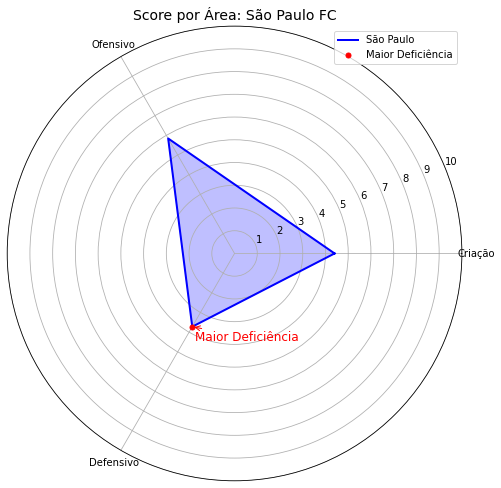

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Tenta converter para Pandas se estiver como PySpark DataFrame
try:
    df_sp = df_desemp_clubes.toPandas()
except:
    pass  # Se já for Pandas, segue em frente

# 🔎 Filtra os dados apenas para o clube São Paulo
df_sp = df_sp[df_sp['clube'] == 'São Paulo'].set_index('clube')

# 📊 Define os eixos do gráfico de radar (as "categorias")
categorias = ['Criação', 'Ofensivo', 'Defensivo']

# 🔢 Pega os valores dos scores nas 3 áreas
valores = df_sp.loc["São Paulo"][['score_criacao', 'score_ofensivo', 'score_defensivo']].tolist()

# 🟥 Identifica qual foi o menor valor (maior deficiência)
idx_menor = np.argmin(valores)                 # índice do menor valor
categoria_menor = categorias[idx_menor]        # nome da área correspondente
valor_menor = valores[idx_menor]               # valor do score mais baixo

# 🔁 Fecha o gráfico de radar (repete o 1º valor no final para formar o círculo)
valores += [valores[0]]
angulos = np.linspace(0, 2 * np.pi, len(valores))  # ângulos para distribuir os eixos no radar

# 🎯 Cria o gráfico polar (radar)
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# 🔷 Linha principal com os scores
ax.plot(angulos, valores, label='São Paulo', color='blue', linewidth=2)
ax.fill(angulos, valores, color='blue', alpha=0.25)

# 🔴 Destaca visualmente o menor score (maior deficiência)
ax.plot(angulos[idx_menor], valor_menor, 'ro', markersize=5, label='Maior Deficiência')

# 📌 Adiciona anotação com seta apontando para o ponto fraco
ax.annotate("Maior Deficiência",
            xy=(angulos[idx_menor], valor_menor),
            xytext=(angulos[idx_menor] + 0.1, valor_menor + 0.5),
            textcoords='data',
            fontsize=12,
            color='red',
            arrowprops=dict(arrowstyle="->", color='red'))

# 🎨 Estética do gráfico
ax.set_xticks(angulos[:-1])                    # Define os rótulos dos eixos
ax.set_xticklabels(categorias)                # Aplica os nomes das categorias
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Define os valores do eixo radial
ax.set_title('Score por Área: São Paulo FC', fontsize=14)
ax.legend(loc='upper right')                   # Coloca a legenda
plt.tight_layout()
plt.show()


#### 0️⃣6️⃣ 🎯 Resposta
O Gráfico de Rede plotado mostra claramente que o setor com maior deficiência do São Paulo é o setor Defensivo.
O score defensivo aponta 3.72, enquanto os scores ofensivo e criação ficaram em 5.84 e 4.4.

---

### 0️⃣7️⃣ Quais métricas contribuíram para esse desempenho ruim em cada aspecto?

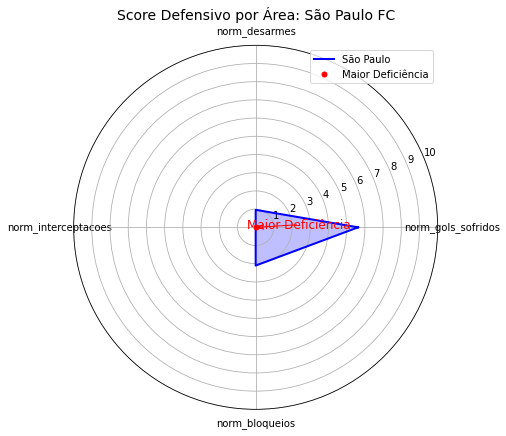

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Tenta converter para Pandas se estiver como PySpark DataFrame
try:
    df_sp = df_desemp_clubes.toPandas()
except:
    pass  # Se já for Pandas, segue em frente

# 🔎 Filtra os dados apenas para o clube São Paulo
df_sp = df_sp[df_sp['clube'] == 'São Paulo'].set_index('clube')

# 📊 Define os eixos do gráfico de radar (as "categorias")
categorias = ['norm_gols_sofridos', 'norm_desarmes', 'norm_interceptacoes', 'norm_bloqueios']

# 🔢 Pega os valores dos scores nas 3 áreas
valores = df_sp.loc["São Paulo"][['norm_gols_sofridos', 'norm_desarmes', 'norm_interceptacoes', 'norm_bloqueios']].tolist()

# 🟥 Identifica qual foi o menor valor (maior deficiência)
idx_menor = np.argmin(valores)                 # índice do menor valor
categoria_menor = categorias[idx_menor]        # nome da área correspondente
valor_menor = valores[idx_menor]               # valor do score mais baixo

# 🔁 Fecha o gráfico de radar (repete o 1º valor no final para formar o círculo)
valores += [valores[0]]
angulos = np.linspace(0, 2 * np.pi, len(valores))  # ângulos para distribuir os eixos no radar

# 🎯 Cria o gráfico polar (radar)
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# 🔷 Linha principal com os scores
ax.plot(angulos, valores, label='São Paulo', color='blue', linewidth=2)
ax.fill(angulos, valores, color='blue', alpha=0.25)

# 🔴 Destaca visualmente o menor score (maior deficiência)
ax.plot(angulos[idx_menor], valor_menor, 'ro', markersize=5, label='Maior Deficiência')

# 📌 Adiciona anotação com seta apontando para o ponto fraco
ax.annotate("Maior Deficiência",
            xy=(angulos[idx_menor], valor_menor),
            xytext=(angulos[idx_menor] + 0.1, valor_menor + 0.5),
            textcoords='data',
            fontsize=12,
            color='red',
            arrowprops=dict(arrowstyle="->", color='red'))

# 🎨 Estética do gráfico
ax.set_xticks(angulos[:-1])                    # Define os rótulos dos eixos
ax.set_xticklabels(categorias)                # Aplica os nomes das categorias
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Define os valores do eixo radial
ax.set_title('Score Defensivo por Área: São Paulo FC', fontsize=14)
ax.legend(loc='upper right')                   # Coloca a legenda
plt.tight_layout()
plt.show()

#### 0️⃣7️⃣ 🎯 Resposta
Ao aprofundar a análise do Score Defensivo, observamos que a maior deficiência do São Paulo está no critério de interceptações.

Conforme ilustrado no gráfico, o clube apresenta valor zero nessa métrica normalizada, o que indica que o São Paulo teve o pior desempenho entre os 20 clubes do campeonato neste quesito. Essa fragilidade nas interceptações contribui diretamente para o baixo desempenho defensivo geral da equipe.

---

### 0️⃣8️⃣ Quais são os 10 jogadores com o melhor desempenho na pior métrica defensiva do São Paulo (_`norm_interceptacoes`_)? 


In [0]:
%sql
SELECT 
    d.jogador,
    d.clube,
    d.norm_gols_sofridos_clube,
    d.norm_desarmes,
    d.norm_interceptacoes,
    d.norm_bloqueios,
    d.score_defensivo
-- Como a maior deficiencia do São Paulo foi nas Interceptações, vamos filtrar baseado nesse critério
FROM marts_mvp_brasileirao.desempenho_jogadores d
ORDER BY norm_interceptacoes DESC
LIMIT 10

jogador,clube,norm_gols_sofridos_clube,norm_desarmes,norm_interceptacoes,norm_bloqueios,score_defensivo
Luciano Juba,Bahia,3.75,4.85,10.0,4.21,4.67
Wagner,EC Vitória,2.81,3.71,9.62,8.6,4.01
Rodrigo Fagundes,Criciúma,0.0,4.23,9.62,9.3,2.48
Alexandro Bernabei,Internacional,7.81,5.77,9.42,4.56,7.3
Adriano Martins,Atlético-GO,0.94,4.02,9.42,6.32,2.83
William,Cruzeiro,6.25,10.0,9.23,9.12,7.63
Raniele,Corinthians,5.0,6.49,9.04,7.02,5.88
Paulo Henrique,Vasco da Gama,1.56,9.9,8.85,6.32,4.61
Mathías Villasanti,Grêmio,3.44,8.14,8.65,7.54,5.34
Aníbal Moreno,Palmeiras,8.75,5.77,8.27,4.56,7.75


#### 0️⃣8️⃣ 🎯 Resposta 
Ao analisar os jogadores com mais interceptações, percebe-se que muitos atuam em clubes da parte de baixo da tabela.

Isso acontece porque esses times costumam ser mais atacados, o que gera mais chances de ação defensiva. 

Além disso, a métrica avalia o desempenho individual, e não a eficiência coletiva da defesa. 

Por isso, um jogador pode se destacar mesmo atuando em um sistema defensivo frágil.


---


### 0️⃣9️⃣ Quais são os 10 jogadores com melhor _score_defensivo_ ?


In [0]:
%sql
SELECT 
    d.jogador,
    d.clube,
    d.norm_gols_sofridos_clube,
    d.norm_desarmes,
    d.norm_interceptacoes,
    d.norm_bloqueios,
    d.score_defensivo
-- Como a maior deficiencia do São Paulo foi nas Interceptações, vamos filtrar baseado nesse critério
FROM marts_mvp_brasileirao.desempenho_jogadores d
ORDER BY d.score_defensivo DESC
LIMIT 10

jogador,clube,norm_gols_sofridos_clube,norm_desarmes,norm_interceptacoes,norm_bloqueios,score_defensivo
Gregore,Botafogo,10.0,10.0,6.35,6.49,9.46
Cuiabano,Botafogo,10.0,5.05,4.42,3.68,7.89
Marlon Freitas,Botafogo,10.0,4.43,3.65,5.79,7.76
Luiz Henrique,Botafogo,10.0,4.85,2.12,6.67,7.76
Aníbal Moreno,Palmeiras,8.75,5.77,8.27,4.56,7.75
Bastos,Botafogo,10.0,3.3,5.96,4.74,7.66
William,Cruzeiro,6.25,10.0,9.23,9.12,7.63
Alexander Barboza,Botafogo,10.0,3.09,5.96,4.74,7.61
Richard Ríos,Palmeiras,8.75,6.7,4.42,4.74,7.6
Marcos Rocha,Palmeiras,8.75,5.67,6.35,3.86,7.5


#### 0️⃣9️⃣ 🎯 Resposta 

Ao listar os atletas com melhor Score Defensivo, observamos que a maioria atua por clubes da parte de cima da tabela.

Isso se deve ao fato de termos atribuído um peso maior (60%) para a métrica de Gols Sofridos. 

Assim, jogadores que pertencem a times com defesas mais sólidas tendem a obter notas finais mais altas, mesmo que suas estatísticas individuais não sejam tão expressivas.

---

## 1️⃣0️⃣ Quais os 15 jogadores com melhor _score_defensivo_, fora dos clubes Tier S e A, que poderiam compor o time do São Paulo?

In [0]:
%sql
--- Primeiro filtramos aqueles jogadores com os Melhores Scores, que não sejam do Tier S ou A
WITH top10_score_defensivo AS (
  SELECT 
    d.jogador,
    d.clube,
    c.tier_clubes,
    d.norm_gols_sofridos_clube,
    d.norm_desarmes,
    d.norm_interceptacoes,
    d.norm_bloqueios,
    d.score_defensivo
  FROM marts_mvp_brasileirao.desempenho_jogadores d
  LEFT JOIN marts_mvp_brasileirao.classificacao_tier c
    ON d.clube = c.clube
  WHERE c.tier_clubes NOT IN ('TIER A', 'TIER S')
  ORDER BY d.score_defensivo DESC
  LIMIT 15
)

--- Depois ordenamos novamente essa tabela pelos gols_sofridos (Crescente)
--- Os gols sofridos tem um impacto grande devido ao peso de 50%,
--- Então 'isolamos' ele para focar no desempenho individual de cada jogador. 
SELECT *
FROM top10_score_defensivo
ORDER BY norm_gols_sofridos_clube ASC


jogador,clube,tier_clubes,norm_gols_sofridos_clube,norm_desarmes,norm_interceptacoes,norm_bloqueios,score_defensivo
Mathías Villasanti,Grêmio,TIER B,3.44,8.14,8.65,7.54,5.34
Dodi,Grêmio,TIER B,3.44,8.14,7.31,5.26,5.09
Lucas Esquivel,Athletico-PR,TIER C,4.69,8.04,6.73,5.09,5.75
Samuel Xavier,Fluminense,TIER B,6.88,5.26,5.38,3.51,6.16
Martinelli,Fluminense,TIER B,6.88,4.33,4.23,7.54,6.01
Jhon Arias,Fluminense,TIER B,6.88,5.05,2.5,6.14,5.95
Thiago dos Santos,Fluminense,TIER B,6.88,3.81,5.77,4.04,5.86
Lima,Fluminense,TIER B,6.88,4.02,3.85,2.98,5.67
Diogo Barbosa,Fluminense,TIER B,6.88,3.81,3.08,1.58,5.47
Ganso,Fluminense,TIER B,6.88,3.51,2.69,2.63,5.41


#### 1️⃣0️⃣ 🎯 Resposta 

Para identificar talentos com alto desempenho individual, mesmo em clubes com defesas menos eficientes, realizamos uma ordenação crescente pela métrica `norm_gols_sofridos_clube`.

Essa escolha “isolou” o impacto do desempenho coletivo, que tem peso elevado no Score Final (60%), permitindo destacar atletas que se sobressaem pelas suas estatísticas próprias, como desarmes, interceptações e bloqueios.

Foi nesse contexto que surgiram nomes como Mathías Villasanti, Dodi, Lucas Esquivel e Samuel Xavier — jogadores que, apesar de atuarem por clubes com desempenho defensivo coletivo inferior, apresentam ótimos indicadores individuais e merecem atenção como possíveis reforços.


---

## 1️⃣1️⃣ Em que posição esses 15 jogadores atuam?

In [0]:
%sql
WITH top5_score_defensivo AS (
  SELECT 
    d.jogador,
    d.clube,
    c.tier_clubes,
    d.norm_gols_sofridos_clube,
    d.norm_desarmes,
    d.norm_interceptacoes,
    d.norm_bloqueios,
    d.score_defensivo
  FROM marts_mvp_brasileirao.desempenho_jogadores d
  LEFT JOIN marts_mvp_brasileirao.classificacao_tier c
    ON d.clube = c.clube
  WHERE c.tier_clubes NOT IN ('TIER A', 'TIER S')
  ORDER BY d.score_defensivo DESC
  LIMIT 15
),
top5_jogadores_defensivos AS (
  SELECT 
    jogador,
    norm_gols_sofridos_clube,
    ROW_NUMBER() OVER (ORDER BY norm_gols_sofridos_clube ASC) AS posicao_ranking
  FROM top5_score_defensivo
)

SELECT 
  CONCAT('Reforco_', j.posicao_ranking) AS Reforco,
  j.jogador,
  i.posicao_principal,
  i.nome_posicao_principal,
  i.jogos_posicao_principal,
  i.improvisacao,
  i.nome_improvisacao,
  i.jogos_improvisados
FROM top5_jogadores_defensivos j
LEFT JOIN marts_mvp_brasileirao.informacao_jogadores i
  ON j.jogador = i.jogador
ORDER BY j.posicao_ranking


Reforco,jogador,posicao_principal,nome_posicao_principal,jogos_posicao_principal,improvisacao,nome_improvisacao,jogos_improvisados
Reforco_1,Mathías Villasanti,DM,Volante,18,CM,Meio-Campista Central,9
Reforco_2,Dodi,DM,Volante,20,CM,Meio-Campista Central,13
Reforco_3,Lucas Esquivel,LB,Lateral Esquerdo,28,CB,Zagueiro,4
Reforco_4,Samuel Xavier,RB,Lateral Direito,32,WB,Ala,1
Reforco_5,Martinelli,DM,Volante,29,CM,Meio-Campista Central,5
Reforco_6,Jhon Arias,RW,Ponta Direita,22,LW,Ponta Esquerda,8
Reforco_7,Thiago dos Santos,CB,Zagueiro,26,LB,Lateral Esquerdo,2
Reforco_8,Lima,DM,Volante,14,AM,Meia Ofensivo,13
Reforco_9,Diogo Barbosa,LB,Lateral Esquerdo,25,WB,Ala,1
Reforco_10,Ganso,AM,Meia Ofensivo,28,DM,Volante,3


#### 1️⃣1️⃣ 🎯 Resposta

Aqui listamos a posição principal de cada jogador e o número de partidas que atuaram nessa função.

Também destacamos as improvisações, que mostram se o atleta atuou fora de sua posição original e quantas vezes isso aconteceu.

Essa informação é útil para identificar jogadores com maior versatilidade tática, ou seja, que podem assumir diferentes funções em campo em caso de necessidade.

---

## 1️⃣2️⃣ O possível reforço é melhor que o jogador atual do São Paulo na mesma posição?

Para avaliar se **Mathías Villasanti** seria uma boa contratação, comparamos seus números com o principal volante do São Paulo em 2024.  
A análise foi feita com base nas métricas defensivas normalizadas, considerando desarmes, interceptações e bloqueios.


#### 🔹 Descobrindo o melhor jogador do São Paulo nessa mesma função `DM`

In [0]:
%sql
SELECT 
  d.jogador,
  d.clube,
  d.norm_desarmes,
  d.norm_interceptacoes,
  d.norm_bloqueios,
  d.norm_gols_sofridos_clube,
  d.score_defensivo
FROM marts_mvp_brasileirao.desempenho_jogadores d
JOIN (
  SELECT jogador
  FROM marts_mvp_brasileirao.informacao_jogadores
  WHERE clube = 'São Paulo' AND posicao_principal = 'DM'
  ORDER BY jogos_posicao_principal DESC
  LIMIT 1
) i
ON d.jogador = i.jogador AND d.clube = 'São Paulo'


jogador,clube,norm_desarmes,norm_interceptacoes,norm_bloqueios,norm_gols_sofridos_clube,score_defensivo
Luiz Gustavo,São Paulo,4.23,5.58,3.51,5.63,5.17


#### 🔹 Pegamos as métricas desses dois jogadores 

In [0]:
df_comparacao  = df_desemp_jogadores.filter(
    ((df_desemp_jogadores.jogador == "Luiz Gustavo") & (df_desemp_jogadores.clube == "São Paulo")) |
    ((df_desemp_jogadores.jogador == "Mathías Villasanti") & (df_desemp_jogadores.clube == "Grêmio"))
)

df_comparacao = df_comparacao.select(
    "jogador",
    "clube",
    "norm_desarmes",
    "norm_interceptacoes",
    "norm_bloqueios",
    "norm_gols_sofridos_clube",
    "score_defensivo"
)

#### 🔹Plotamos em um Gráfico de Radar para comparar os atributos desses dois jogadores 

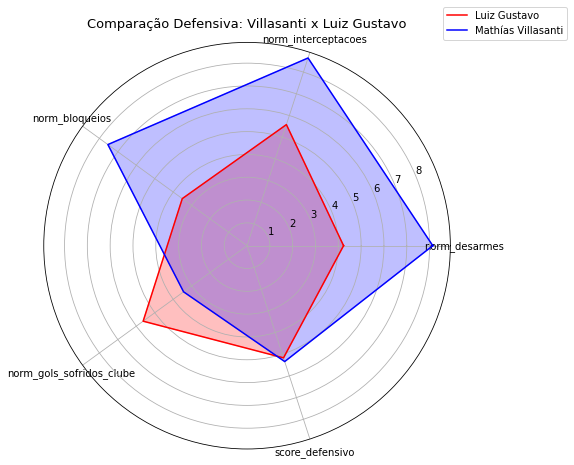

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Tenta converter para Pandas se estiver como PySpark DataFrame
try:
    df_pd = df_comparacao.toPandas()
except:
    pass  # Se já for Pandas, segue em frente

df_pd.set_index("jogador", inplace=True)

# Pegar os rótulos das métricas
labels = df_pd.columns.drop("clube").tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Cores específicas
cores = {
    "Luiz Gustavo": "red",
    "Mathías Villasanti": "blue"
}

# Criar gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for jogador in df_pd.index:
    valores = df_pd.loc[jogador, labels].tolist()
    valores += valores[:1]
    cor = cores.get(jogador, "gray")                    # 🟢 AQUI estamos usando a cor correta
    ax.plot(angles, valores, label=jogador, color=cor)  # ⬅️ color aplicado aqui
    ax.fill(angles, valores, color=cor, alpha=0.25)     # ⬅️ e aqui também

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Comparação Defensiva: Villasanti x Luiz Gustavo", fontsize=13)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


#### 1️⃣2️⃣ 🎯 Resposta

Aqui realizamos um comparativo entre dois jogadores:

- **Villasanti**, com o melhor desempenho individual na posição;

- **Luiz Gustavo**, atleta que atualmente ocupa essa função no São Paulo.

Ao analisar as métricas individuais, fica evidente que **Villasanti** apresenta números superiores, demonstrando ser uma excelente opção de reforço para a próxima temporada, agregando mais solidez ao setor defensivo do time.

---

## 1️⃣3️⃣ A segunda maior deficiência do São Paulo é na Criação, então mostre 10 opções de jogadores para compor o Elenco

In [0]:
%sql
--- Primeiro filtramos aqueles jogadores com os Melhores Scores, que não sejam do Tier S ou A
WITH top10_score_criacao AS (
  SELECT 
    d.jogador,
    d.clube,
    c.tier_clubes,
    d.norm_ass,
    d.norm_acoes_de_criacao,
    d.norm_ass_esperadas,
    d.norm_passes_completos,
    d.norm_passes_tentados,
    d.norm_conducoes_de_bola,
    d.norm_conducoes_progressivas,
    d.score_criacao
  FROM marts_mvp_brasileirao.desempenho_jogadores d
  LEFT JOIN marts_mvp_brasileirao.classificacao_tier c
    ON d.clube = c.clube
  WHERE c.tier_clubes NOT IN ('TIER A', 'TIER S')
  ORDER BY d.score_criacao DESC
  LIMIT 10
)

--- Depois ordenamos novamente essa tabela pelos gols_sofridos (Crescente)
--- Os gols sofridos tem um impacto grande devido ao peso de 50%,
--- Então 'isolamos' ele para focar no desempenho individual de cada jogador. 
SELECT *
FROM top10_score_criacao


jogador,clube,tier_clubes,norm_ass,norm_acoes_de_criacao,norm_ass_esperadas,norm_passes_completos,norm_passes_tentados,norm_conducoes_de_bola,norm_conducoes_progressivas,score_criacao
Ganso,Fluminense,TIER B,7.0,5.34,4.15,6.5,6.87,5.87,1.1,5.5
João Lucas,Juventude,TIER B,6.0,4.5,5.12,4.52,6.03,4.73,4.9,5.19
Tomás Cuello,Athletico-PR,TIER C,5.0,5.5,5.0,2.79,3.67,4.04,7.1,5.06
Gustavo Scarpa,Atlético-MG,TIER B,4.0,5.5,4.39,5.33,6.43,6.24,6.21,4.86
Marcelo Hermes,Criciúma,TIER C,5.0,5.81,3.54,4.92,6.63,4.57,3.45,4.86
Franco Cristaldo,Grêmio,TIER B,2.0,6.6,6.59,4.28,5.12,4.25,2.14,4.82
Lucas Esquivel,Athletico-PR,TIER C,4.0,4.61,5.24,6.53,7.77,6.28,3.93,4.81
Jadson,Juventude,TIER B,5.0,5.45,3.9,4.76,5.19,4.58,1.17,4.7
Bruno Zapelli,Athletico-PR,TIER C,5.0,4.45,5.37,2.49,3.13,3.09,2.55,4.6
Jhon Arias,Fluminense,TIER B,3.0,5.6,4.27,4.87,5.28,5.71,6.41,4.48


#### 1️⃣3️⃣ 🎯 Resposta

Agora estamos em busca de um atleta que possa suprir a segunda maior deficiência do São Paulo: a criação de jogadas.

Para isso, listamos os 10 jogadores com melhor desempenho no Score de Criação, excluindo aqueles que atuam nos Tiers mais altos do campeonato.

O objetivo é encontrar boas opções fora do radar principal, com alto desempenho individual, mas que sejam viáveis como reforços.

---

## 1️⃣4️⃣ Em que posição esses 10 jogadores atuam?

In [0]:
%sql
WITH top10_score_criacao AS (
  SELECT 
    d.jogador,
    d.clube,
    c.tier_clubes,
    d.norm_ass,
    d.norm_acoes_de_criacao,
    d.norm_ass_esperadas,
    d.norm_passes_completos,
    d.norm_passes_tentados,
    d.norm_conducoes_de_bola,
    d.norm_conducoes_progressivas,
    d.score_criacao
  FROM marts_mvp_brasileirao.desempenho_jogadores d
  LEFT JOIN marts_mvp_brasileirao.classificacao_tier c
    ON d.clube = c.clube
  WHERE c.tier_clubes NOT IN ('TIER A', 'TIER S')
  ORDER BY d.score_criacao DESC
  LIMIT 10
),

top10_jogadores_criacao AS (
  SELECT 
    jogador,
    ROW_NUMBER() OVER (ORDER BY score_criacao DESC) AS posicao_ranking
  FROM top10_score_criacao
)

SELECT 
  CONCAT('Reforco_', j.posicao_ranking) AS Reforco,
  j.jogador,
  i.posicao_principal,
  i.nome_posicao_principal,
  i.jogos_posicao_principal,
  i.improvisacao,
  i.nome_improvisacao,
  i.jogos_improvisados
FROM top10_jogadores_criacao j
LEFT JOIN marts_mvp_brasileirao.informacao_jogadores i
  ON j.jogador = i.jogador
ORDER BY j.posicao_ranking;


Reforco,jogador,posicao_principal,nome_posicao_principal,jogos_posicao_principal,improvisacao,nome_improvisacao,jogos_improvisados
Reforco_1,Ganso,AM,Meia Ofensivo,28,DM,Volante,3
Reforco_2,João Lucas,RB,Lateral Direito,30,null,null,null
Reforco_3,Tomás Cuello,LW,Ponta Esquerda,14,RW,Ponta Direita,8
Reforco_4,Gustavo Scarpa,WB,Ala,18,RM,Meia Direita,6
Reforco_5,Marcelo Hermes,LB,Lateral Esquerdo,25,LM,Meia Esquerda,9
Reforco_6,Franco Cristaldo,AM,Meia Ofensivo,18,FW,Atacante,13
Reforco_7,Lucas Esquivel,LB,Lateral Esquerdo,28,CB,Zagueiro,4
Reforco_8,Jadson,DM,Volante,26,CM,Meio-Campista Central,5
Reforco_8,Jadson,FW,Atacante,3,RM,Meia Direita,2
Reforco_9,Bruno Zapelli,AM,Meia Ofensivo,20,RM,Meia Direita,4


#### 1️⃣4️⃣ 🎯 Resposta

Nessa etapa iremos identificar em que posição esses atletas atuam, assim como se eles já jogaram improvisados em algum momento e quantos jogos.

---



## 1️⃣5️⃣ O possível reforço é melhor que o jogador atual do São Paulo na mesma posição?

Para avaliar se **Ganso** seria uma boa contratação, comparamos seus números com o principal Meia Ofensivo do São Paulo em 2024.  
A análise foi feita com base nas métricas Criação normalizadas

#### 🔹 Descobrindo o melhor jogador do São Paulo nessa mesma função `DM`

In [0]:
%sql
SELECT 
  d.jogador,
  d.clube,
  i.posicao_principal,
  i.jogos_posicao_principal,
  d.norm_ass,
  d.norm_acoes_de_criacao,
  d.norm_ass_esperadas,
  d.norm_passes_completos,
  d.norm_passes_tentados,
  d.norm_conducoes_de_bola,
  d.norm_conducoes_progressivas,
  d.score_criacao
FROM marts_mvp_brasileirao.desempenho_jogadores d
JOIN (
  SELECT i.jogador, i.jogos_posicao_principal, i.posicao_principal
  FROM marts_mvp_brasileirao.informacao_jogadores i
  WHERE clube = 'São Paulo' AND posicao_principal = 'AM'
  ORDER BY jogos_posicao_principal DESC
  LIMIT 3
) i
ON d.jogador = i.jogador AND d.clube = 'São Paulo'


jogador,clube,posicao_principal,jogos_posicao_principal,norm_ass,norm_acoes_de_criacao,norm_ass_esperadas,norm_passes_completos,norm_passes_tentados,norm_conducoes_de_bola,norm_conducoes_progressivas,score_criacao
Rodrigo,São Paulo,AM,3,0.0,0.05,0.0,0.13,0.15,0.17,0.34,0.04
Luciano,São Paulo,AM,27,2.0,3.14,2.68,3.49,3.74,4.11,1.66,2.7
James Rodríguez,São Paulo,AM,2,0.0,0.1,0.0,0.16,0.19,0.17,0.0,0.05


#### 🔹 Pegamos as métricas desses dois jogadores 

In [0]:
df_comparacao  = df_desemp_jogadores.filter(
    ((df_desemp_jogadores.jogador == "Luciano") & (df_desemp_jogadores.clube == "São Paulo")) |
    ((df_desemp_jogadores.jogador == "Ganso") & (df_desemp_jogadores.clube == "Fluminense"))
)

df_comparacao = df_comparacao.select(
    "jogador",
    "clube",
    "norm_ass",
    "norm_acoes_de_criacao",
    "norm_ass_esperadas",
    "norm_passes_completos",
    "norm_passes_tentados",
    "norm_conducoes_de_bola",
    "norm_conducoes_progressivas",
    "score_criacao"
)

#### 🔹Plotamos em um Gráfico de Radar para comparar os atributos desses dois jogadores 

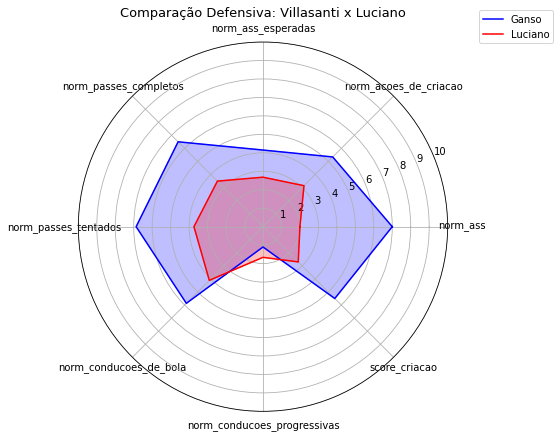

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Tenta converter para Pandas se estiver como PySpark DataFrame
try:
    df_pd = df_comparacao.toPandas()
except:
    pass  # Se já for Pandas, segue em frente

df_pd.set_index("jogador", inplace=True)

# Pegar os rótulos das métricas
labels = df_pd.columns.drop("clube").tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Cores específicas
cores = {
    "Luciano": "red",
    "Ganso": "blue"
}

# Criar gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for jogador in df_pd.index:
    valores = df_pd.loc[jogador, labels].tolist()
    valores += valores[:1]
    cor = cores.get(jogador, "gray")                    # 🟢 AQUI estamos usando a cor correta
    ax.plot(angles, valores, label=jogador, color=cor)  # ⬅️ color aplicado aqui
    ax.fill(angles, valores, color=cor, alpha=0.25)     # ⬅️ e aqui também

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Comparação Defensiva: Villasanti x Luciano", fontsize=13)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Define os valores do eixo radial
plt.tight_layout()
plt.show()


#### 1️⃣5️⃣ 🎯 Resposta

Ao comparar os dois atletas, percebemos que o Ganso exerce com mais eficiência a função de meia de criação do que o Luciano.

Enquanto Ganso se destaca na construção de jogadas, Luciano atua com um perfil mais ofensivo, sendo um jogador que finaliza mais do que cria.

Isso reforça a ideia de que o time pode se beneficiar com a entrada de um meia mais criativo, especialmente para suprir a carência nessa função.


---


## 1️⃣6️⃣ Como foi o Desempenho do São Paulo no seu melhor SCORE (`Ofensivo`)?

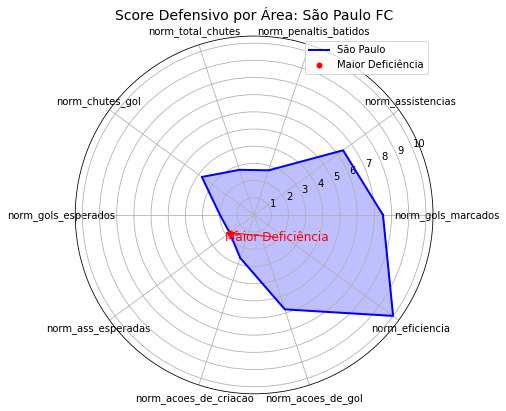

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Tenta converter para Pandas se estiver como PySpark DataFrame
try:
    df_sp = df_desemp_clubes.toPandas()
except:
    pass  # Se já for Pandas, segue em frente

# 🔎 Filtra os dados apenas para o clube São Paulo
df_sp = df_sp[df_sp['clube'] == 'São Paulo'].set_index('clube')

# 📊 Define os eixos do gráfico de radar (as "categorias")
categorias = ['norm_gols_marcados', 'norm_assistencias', 'norm_penaltis_batidos', 'norm_total_chutes', 'norm_chutes_gol', 'norm_gols_esperados', 'norm_ass_esperadas',       
              'norm_acoes_de_criacao', 'norm_acoes_de_gol', 'norm_eficiencia']

# 🔢 Pega os valores dos scores nas 3 áreas
valores = df_sp.loc["São Paulo"][['norm_gols_marcados', 'norm_assistencias', 'norm_penaltis_batidos', 'norm_total_chutes', 'norm_chutes_gol', 'norm_gols_esperados',      
                                  'norm_ass_esperadas', 'norm_acoes_de_criacao', 'norm_acoes_de_gol', 'norm_eficiencia']].tolist()

# 🟥 Identifica qual foi o menor valor (maior deficiência)
idx_menor = np.argmin(valores)                 # índice do menor valor
categoria_menor = categorias[idx_menor]        # nome da área correspondente
valor_menor = valores[idx_menor]               # valor do score mais baixo

# 🔁 Fecha o gráfico de radar (repete o 1º valor no final para formar o círculo)
valores += [valores[0]]
angulos = np.linspace(0, 2 * np.pi, len(valores))  # ângulos para distribuir os eixos no radar

# 🎯 Cria o gráfico polar (radar)
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# 🔷 Linha principal com os scores
ax.plot(angulos, valores, label='São Paulo', color='blue', linewidth=2)
ax.fill(angulos, valores, color='blue', alpha=0.25)

# 🔴 Destaca visualmente o menor score (maior deficiência)
ax.plot(angulos[idx_menor], valor_menor, 'ro', markersize=5, label='Maior Deficiência')

# 📌 Adiciona anotação com seta apontando para o ponto fraco
ax.annotate("Maior Deficiência",
            xy=(angulos[idx_menor], valor_menor),
            xytext=(angulos[idx_menor] + 0.1, valor_menor + 0.5),
            textcoords='data',
            fontsize=12,
            color='red',
            arrowprops=dict(arrowstyle="->", color='red'))

# 🎨 Estética do gráfico
ax.set_xticks(angulos[:-1])                    # Define os rótulos dos eixos
ax.set_xticklabels(categorias)                # Aplica os nomes das categorias
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Define os valores do eixo radial
ax.set_title('Score Defensivo por Área: São Paulo FC', fontsize=14)
ax.legend(loc='upper right')                   # Coloca a legenda
plt.tight_layout()
plt.show()

#### 1️⃣6️⃣ 🎯 Resposta

Agora conseguimos visualizar os números do São Paulo no quesito ofensividade.

Um destaque importante vai para a métrica de norm_eficiencia, que mostra que o São Paulo é o time mais eficiente na conversão de chances em gols.

Apesar de não estar entre os clubes que mais criam oportunidades de gol (norm_gols_esperados), o time aproveita muito bem as chances que tem, convertendo com alta frequência.

---

## 1️⃣7️⃣ Qual é a eficiência da finalização do São Paulo?
Comparamos os gols marcados pelo São Paulo com os Expected Goals (xG), avaliando se o time converteu bem suas chances ou desperdiçou oportunidades.

In [0]:
%sql
SELECT 
  e.Clube,
  SUM(e.Gols) AS total_gols,
  ROUND(SUM(e.Gols_Esperados), 2) AS total_xg,
  CONCAT(ROUND(SUM(e.Gols) / NULLIF(SUM(e.Gols_Esperados), 0) * 100, 1), '%') AS eficiencia_finalizacao_pct
FROM default.brasil_seriea_2024_silver_estatistica_jogador e
WHERE e.Clube = 'São Paulo'
GROUP BY e.Clube


Clube,total_gols,total_xg,eficiencia_finalizacao_pct
São Paulo,51,38.3,133.2%


### 1️⃣7️⃣ 🎯 Resposta

O São Paulo marcou 51 gols, enquanto o valor esperado de gols (xG) era de 38,3. Isso resulta em uma eficiência de finalização de 133,2%, ou seja, o time converteu 33% a mais do que o esperado com base nas chances criadas.

Esse número mostra que, apesar de não estar entre os clubes que mais criam oportunidades, o São Paulo é extremamente eficiente quando chega ao ataque, aproveitando muito bem suas finalizações.